## Try phase association for stations for 2012
Refernce: https://github.com/yetinam/pyocto

In [1]:
# !pip3 install numpy
# !pip3 install pyrocko

In [2]:
import pyocto
import pandas as pd
import datetime
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from scipy import signal
from obspy.signal.trigger import classic_sta_lta
import pygmt

from obspy.clients.fdsn import Client
from obspy.core.utcdatetime import UTCDateTime
from pnwstore.mseed import WaveformClient


In [3]:
# Import the velocity model from https://colab.research.google.com/github/yetinam/pyocto/blob/main/examples/02_velocity_models.ipynb#scrollTo=1c52ed9e-d9c1-4fa6-a549-de702bc9d439
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

## Input Data

In [4]:
picks = pd.read_csv("../data/datasets_swa_shelf_trench/picks_swa_shelf_trench.csv",index_col=0)
stations = pd.read_csv("../data/datasets_swa_shelf_trench/all_stations_swa_shelf_trench.csv",index_col=0)

In [5]:
picks

,station,phase,time
0,FN07A,P,2012-01-01T00:02:00.833000Z
1,FN07A,P,2012-01-01T00:03:53.009000Z
2,FN07A,P,2012-01-01T00:07:18.433000Z
3,FN07A,P,2012-01-01T00:15:37.169000Z
4,FN07A,P,2012-01-01T00:16:36.929000Z
...,...,...,...
5898904,J42A,S,2011-12-13T21:50:08.029000Z
5898905,J42A,S,2011-12-13T22:25:12.557000Z
5898906,J42A,S,2011-12-13T23:09:29.949000Z
5898907,J42A,S,2011-12-13T23:11:31.781000Z


In [6]:
stations

,id,longitude,latitude,elevation
0,FN07A,-124.786499,46.855499,-154.0
1,J57A,-124.450500,47.080101,-55.8
2,J50A,-125.299103,46.640202,-1909.0
3,J49A,-124.427498,46.437801,-120.0
4,J42A,-125.299698,45.933102,-1540.0
5,FN14A,-124.964699,47.024799,-173.0
6,FN16A,-125.516098,46.799599,-1907.0
7,J58A,-125.534401,47.318802,-1511.0
8,FN07C,-124.786003,46.855400,-158.0
9,J50C,-125.298698,46.641102,-1931.0


## Create a 1D velocity model
Not needed for now.

In [7]:
# !wget https://github.com/yetinam/pyocto/raw/main/tests/data/graeber.csv

In [8]:
layers = pd.read_csv("../data/swa_shelf_trench.csv")

# Strip leading/trailing spaces from column names
layers.columns = layers.columns.str.strip()
layers

,depth,vp,vp_grad,vs,vs_grad,x,y
0,0.0,1.9,0.666667,1.096966,0.384900,1,0
1,0.9,2.5,0.434783,1.443376,0.251022,1,0
2,3.2,3.5,0.769231,2.020726,0.444116,1,0
3,4.5,4.5,0.333333,2.598076,0.192450,1,0
4,6.9,5.3,0.538462,3.059956,0.310881,1,0
5,8.2,6.0,0.266667,3.464102,0.153960,1,0
6,9.7,6.4,0.312500,3.695042,0.180422,1,0
7,11.3,6.9,0.062500,3.983717,0.036084,1,0
8,12.9,7.0,0.625000,4.041452,0.360844,1,0
9,14.5,8.0,0.625000,4.618802,0.360844,1,0


In [9]:
model_path = "velocity_model"
pyocto.VelocityModel1D.create_model(layers, 1., 400, 250, model_path)

In [10]:
velocity_model_1d = pyocto.VelocityModel1D(model_path, tolerance=2.0)

## The OctoAssociator class

In [11]:
#  Define the associator parameters
associator = pyocto.OctoAssociator.from_area(
    lat=(38, 51),
    lon=(-132, -119),
    zlim=(0, 50),
    time_before=300,
    velocity_model=velocity_model_1d,
    n_picks=5,
    n_p_picks=1,
    n_s_picks=3,
    n_p_and_s_picks=1,
)

In [12]:
associator.transform_stations(stations)
stations

,id,longitude,latitude,elevation,x,y,z
0,FN07A,-124.786499,46.855499,-154.0,54.412073,262.049185,0.1540
1,J57A,-124.450500,47.080101,-55.8,79.701081,287.305612,0.0558
2,J50A,-125.299103,46.640202,-1909.0,15.381688,237.887900,1.9090
3,J49A,-124.427498,46.437801,-120.0,82.421632,215.928043,0.1200
4,J42A,-125.299698,45.933102,-1540.0,15.534741,159.288748,1.5400
5,FN14A,-124.964699,47.024799,-173.0,40.693969,280.762095,0.1730
6,FN16A,-125.516098,46.799599,-1907.0,-1.228920,255.587847,1.9070
7,J58A,-125.534401,47.318802,-1511.0,-2.600799,313.309129,1.5110
8,FN07C,-124.786003,46.855400,-158.0,54.449999,262.038523,0.1580
9,J50C,-125.298698,46.641102,-1931.0,15.412441,237.988026,1.9310


## Convert the timestamps to floats

In [13]:
# Convert the times to timestamps
picks["time"] = picks["time"].apply(lambda x: datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ'))
picks["time"] = picks["time"].apply(lambda x: x.timestamp())
picks

,station,phase,time
0,FN07A,P,1.325376e+09
1,FN07A,P,1.325376e+09
2,FN07A,P,1.325376e+09
3,FN07A,P,1.325377e+09
4,FN07A,P,1.325377e+09
...,...,...,...
5898904,J42A,S,1.323813e+09
5898905,J42A,S,1.323815e+09
5898906,J42A,S,1.323818e+09
5898907,J42A,S,1.323818e+09


In [14]:
# picks['time'] = picks['time'].apply(lambda x: (datetime.datetime.strptime(x,'%Y-%m-%dT%H:%M:%S.%fZ')).timestamp())
# picks

## Apply  the associator

In [ ]:
# Association 
events, assignments = associator.associate(picks, stations)

In [15]:
# Count how many picks each event has
Counter(events['picks'])

Counter({5: 46762,
         6: 13719,
         7: 2225,
         8: 261,
         9: 32,
         10: 7,
         11: 5,
         12: 2,
         19: 2,
         13: 2,
         16: 2,
         14: 1})

In [16]:
# Convert the event times and the x, y, and z coordinate to latitudes, longitudes, and depths, respectively
associator.transform_events(events)
events["time"] = events["time"].apply(datetime.datetime.fromtimestamp, tz=datetime.timezone.utc)

In [17]:
events

,idx,time,x,y,z,picks,latitude,longitude,depth
0,0,2011-08-03 17:32:18.340407+00:00,73.074550,230.049591,21.484375,5,46.565896,-124.546890,21.484375
1,1,2011-08-03 19:08:05.787240+00:00,57.455562,271.531248,1.953125,5,46.940530,-124.745398,1.953125
2,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625
3,3,2011-08-10 19:41:12.629827+00:00,49.646068,292.987277,7.421875,5,47.134147,-124.845602,7.421875
4,4,2011-08-11 15:50:21.021765+00:00,45.183500,241.492807,38.671875,5,46.671284,-124.909529,38.671875
...,...,...,...,...,...,...,...,...,...
63015,63015,2014-06-28 23:57:42.192383+00:00,7.251673,157.099091,12.890625,5,45.913539,-125.406531,12.890625
63016,63016,2014-06-29 02:45:04.979131+00:00,70.843266,192.859140,42.578125,5,46.231609,-124.581619,42.578125
63017,63017,2014-06-29 09:09:02.520289+00:00,47.414784,260.088032,0.390625,5,46.838394,-124.878451,0.390625
63018,63018,2014-06-29 10:12:29.859310+00:00,61.918130,254.366424,2.734375,5,46.785740,-124.689122,2.734375


In [ ]:
#  Save events that have at least 6 picks
# events = events.loc[(events['picks'] >= 6)]
events.to_csv('../data/datasets_swa_shelf_trench/events_swa_shelf_trench_all.csv')


In [19]:
# events.to_csv('~/notebooks/src/association_events.csv')

In [20]:
# Print the assignments
assignments

,event_idx,pick_idx,residual,station,phase,time
0,0,4044735,0.925266,FN07A,S,1.312393e+09
1,0,1987689,0.176926,FN14A,P,1.312393e+09
2,0,4019793,-1.149971,FN14A,S,1.312393e+09
3,0,1977090,0.354066,J49A,P,1.312393e+09
4,0,4007931,-0.306288,J49A,S,1.312393e+09
...,...,...,...,...,...,...
334329,63019,3636258,-0.954766,FN07C,S,1.404046e+09
334330,63019,1505336,0.991973,FN08C,P,1.404046e+09
334331,63019,3526478,0.069055,FN08C,S,1.404046e+09
334332,63019,1576599,0.198688,FN09C,P,1.404046e+09


In [21]:
# Assign the event information to each pick by using pd.merge
all_pick_assignments = pd.merge(events, assignments, left_on="idx", right_on="event_idx", suffixes=("", "_pick"))
all_pick_assignments

,idx,time,x,y,z,picks,latitude,longitude,depth,event_idx,pick_idx,residual,station,phase,time_pick
0,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,2109680,-0.530608,FN07A,P,1.312886e+09
1,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,4141442,-0.160235,FN07A,S,1.312886e+09
2,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,1939147,-0.348758,FN14A,P,1.312886e+09
3,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,3969523,0.828527,FN14A,S,1.312886e+09
4,2,2011-08-09 10:26:19.132811+00:00,89.809180,255.796826,0.390625,6,46.795434,-124.323648,0.390625,2,2130175,0.505961,J49A,P,1.312886e+09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
100519,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,3095737,-0.039125,FN12C,S,1.403969e+09
100520,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,1037760,1.222291,J49C,P,1.403969e+09
100521,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,3089858,-0.647115,J49C,S,1.403969e+09
100522,63004,2014-06-28 15:26:30.086334+00:00,54.108636,235.771199,37.109375,6,46.619156,-124.793571,37.109375,63004,1375420,-1.186613,J57C,P,1.403969e+09


In [ ]:
# Save the assignments to a CSV file
all_pick_assignments.to_csv("../data/datasets_swa_shelf_trench/all_pick_assignments_swa_shelf_trench_all.csv")

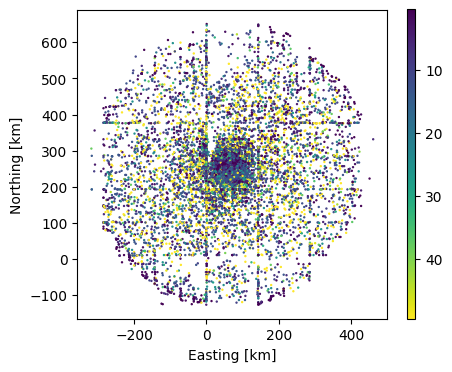

In [23]:
# The parameters in the associator class: n_picks=2,n_p_picks=1,n_s_picks=1,n_p_and_s_picks=1
fig = plt.figure(figsize=(4, 8))
ax = fig.add_subplot()
ax.set_aspect("equal")

# ax.scatter(events["x"], events["y"], c=events["z"])
ax.set_xlabel("Easting [km]")
ax.set_ylabel("Northing [km]")
cax = fig.add_axes([ax.get_position().x1+0.05,ax.get_position().y0,0.02,ax.get_position().height])
cb1 = fig.colorbar(ax.scatter(events["x"], events["y"], c=events["z"],s=0.5,cmap='viridis'), cax=cax)
cb1.ax.invert_yaxis()

## Plot the associated events (not necessary to run cells below)

In [ ]:
# Read the event dataframe saved above
events = pd.read_csv('../data/events_october_temp_with_JCC.csv')

In [ ]:
events

In [ ]:
# Plot the events 
import pygmt
fig = pygmt.Figure()
# grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# # fig.shift_origin(yshift="10c")
# fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
# # fig.plot(x = events_morton_201210_lon, y = events_morton_201210_lat,  
# #          color = 'blue', size = size_morton, style = "c", pen = "black")
# # fig.plot(x = myevents_20121014_lon, y = myevents_20121014_lat,  
# #          color = 'red', size = size_myevents, style = "c", pen = "black")
# # fig.plot(x = events_jdf_201210_lon, y = events_jdf_201210_lat,  
# #          color = 'yellow', size = size_jdf, style = "c", pen = "black")
# # fig.plot(x = events_cascadia_201210_lon, y = events_cascadia_201210_lat,  
# #          color = 'yellow', size = size_cascadia, style = "c", pen = "black")
# # fig.plot(x = events_USGS_201210_lon, y = events_USGS_201210_lat,  
# #          color = 'green', size = size_USGS, style = "c", pen = "black")
# # # Draw a line between two events that we consider to be the same event 
# # Draw a line between two events that we consider to be the same event 
# # fig.plot(x = (event_0239_lon,event_morton_0239_lon), y = (event_0239_lat,event_morton_0239_lat), pen ="4p, red")
# # fig.plot(x = (event_0239_lon,event_morton_0239_lon), y = (event_0239_lat,event_morton_0308_lat), pen ="4p, red")
# fig.plot(x=events["x"], y=events["y"], c=events["z"],s=0.5,cmap='viridis')
# fig.show()

grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-127, -123, 40, 50])
fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
pygmt.makecpt(cmap="hot", series=[min(events['picks'].values), max(events['picks'].values)])
fig.plot(
    x=events["longitude"].values,
    y=events["latitude"].values,
    size=0.3 * np.ones(len(events)),
    fill=events['picks'].values,
    cmap=True,
    style="cc",
    pen="black",
)
fig.colorbar(frame="xaf+lNumber of Picks")
# fig.plot(x=events["longitude"].values[0:200], y=events["latitude"].values[0:200], style="c0.3c", color=events['picks'].values[0:200], cmap='viridis', pen="black")
fig.show()

## Association validation (not necessary anymore) 
Get the events from the USGS and compare with the events from the association


In [ ]:
client = Client("USGS")
client_waveforms = WaveformClient()
client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)


In [ ]:
# Pick a station 
s = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
s.filter(type='bandpass',freqmin=4,freqmax=15)

In [ ]:
# Pick a time that shows up in both the USGS catalog and the event data frame from the association above 
time1 = events.loc[1, 'time']

In [ ]:
time1

In [ ]:
trim_s = s.copy().trim(starttime = UTCDateTime(time1) - 20, 
                endtime = UTCDateTime(time1) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

In [ ]:
# Pick another time that shows up in both the USGS catalog and the event data frame from the association above 
time2 = events.loc[2, 'time']
time2

In [ ]:
trim_s = s.copy().trim(starttime = UTCDateTime(time2) - 20, 
                endtime = UTCDateTime(time2) + 40)
fig = plt.figure(figsize = (10, 4))
trim_s.plot(fig=fig)

# [ax.axvline(pick.peak_time.matplotlib_date, 
#             linestyle = '--', color = 'r', label = f'{pick.phase} pick') for ax in fig.axes]
# [ax.legend() for ax in fig.axes]

## Other Picks

In [ ]:
time = events['time']
time

In [ ]:
time_possibly_new_events = time.drop(labels=[1,2], axis=0)
time_possibly_new_events

In [ ]:
for time in time_possibly_new_events:
    plt.figure(figsize=(10,10))
    for i in range(len(stations)):
        s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
        s = s.select(channel = "[HB]H?")
        s.filter(type='bandpass',freqmin=4,freqmax=15)
        if s[0].stats.channel == 'HH1':
            s = s.resample(50)
        else:
            pass 

        trim_s = s.copy().trim(starttime = UTCDateTime(time) - 10, endtime = UTCDateTime(time) + 50)
        sdata = np.array(trim_s)[:,:]
        sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
        offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

        for ii in range(len(sdata)):
            offsets1  = np.arange(0,len(sdata))
            plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    


    plt.yticks(offsets2+1, stations['id'])
    plt.axvline(time,ls='-', c='r')
    plt.title(time)

In [ ]:
# Plot waveforms of events picked by the associator but not on the USGS catalog
time4 = events.loc[4, 'time']
time4

In [ ]:
# s_FS09B = client_waveforms.get_waveforms(network="7D", station="FS09B", channel="BH?", year=2012, month=10, day=14)
# s_G10B = client_waveforms.get_waveforms(network="7D", station="G10B", channel="BH?", year=2012, month=10, day=14)
# s_G19B = client_waveforms.get_waveforms(network="7D", station="G19B", channel="BH?", year=2012, month=10, day=14)
# s_G25B = client_waveforms.get_waveforms(network="7D", station="G25B", channel="BH?", year=2012, month=10, day=14)
# s_G27B = client_waveforms.get_waveforms(network="7D", station="G27B", channel="BH?", year=2012, month=10, day=14)
# s_J09B = client_waveforms.get_waveforms(network="7D", station="J09B", channel="BH?", year=2012, month=10, day=14)
# s_M12B= client_waveforms.get_waveforms(network="7D", station="M12B", channel="BH?", year=2012, month=10, day=14)
# s_M14B = client_waveforms.get_waveforms(network="7D", station="M14B", channel="BH?", year=2012, month=10, day=14)


In [ ]:
# trim_s_FS09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G10B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G19B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G25B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_G27B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_J09B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M12B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)
# trim_s_M14B = s.copy().trim(starttime = UTCDateTime(time1) - 20, endtime = UTCDateTime(time1) + 40)



In [ ]:
for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    fig = plt.figure(figsize=(10,4))
    trim_s.plot(fig=fig)
    [ax.axvline(pick_time[4], 
            linestyle = '--', color = 'r', label = 'pick time') for ax in fig.axes]    


In [ ]:
offsets1  = np.arange(0,3)
offsets2 = np.arange(0,2*len(stations),2)



In [ ]:
offsets1

In [ ]:
offsets2 = np.arange(0,2*10000*len(stations),2*10000)

offsets2

In [ ]:
plt.figure()
offsets2 = np.arange(0,5*10000*len(stations),5*10000)

for i, station in enumerate(stations['id']):
    s = client_waveforms.get_waveforms(network="7D", station=station, channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 20, endtime = UTCDateTime(pick_time[4]) + 100)
    sdata = np.array(trim_s)[:,:]
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,10000*len(sdata),10000)
        plt.plot(sdata[ii].T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5)   


In [ ]:
offsets2 = np.arange(0,5*100000*len(stations),5*100000)


s = client_waveforms.get_waveforms(network="7D", station=stations['id'][0], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
sampling_rate = s[0].stats.sampling_rate
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

plt.axvline(10*sampling_rate,ls='-', c='r')
    


In [ ]:
sdata.mean()

In [ ]:
s[0].stats.sampling_rate*120

In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

for ii in range(len(sdata)):
    offsets1  = np.arange(0,len(sdata))
    plt.plot(sdata_norm.T+offsets1[ii], color = 'gray', alpha=0.5, lw=0.5)

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')


In [ ]:
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))
offsets2

In [ ]:
np.mean(sdata, axis=1, keepdims=True)

In [ ]:
sdata

In [ ]:
np.mean(sdata[0])

In [ ]:
(sdata - np.mean(sdata, axis=1, keepdims=True))/(np.std(sdata, axis=1, keepdims=True))

In [ ]:
(225.73644077-0.28159811)/20312.08876045

In [ ]:
np.std(sdata, axis=1, keepdims=True) 

In [ ]:
sdata

In [ ]:
np.max(sdata, axis=1, keepdims=True)

In [ ]:
np.min(sdata, axis=1, keepdims=True)

In [ ]:
(sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    if s[0].stats.channel == 'HH1':
        new_rate = 50
        number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
        sdata = signal.resample(sdata, number_of_samples, axis=-1)
    else:
        pass 
    print(len(sdata[-1]))
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(sdata_norm.T+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.5, lw=0.5)    

plt.axvline(10*sampling_rate,ls='-', c='r')
# plt.xlim(0,3000)


In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))

In [ ]:
UTCDateTime(pick_time[4]) - 10

In [ ]:
UTCDateTime(pick_time[4]) + 50

In [ ]:
s[0].stats.sampling_rate

In [ ]:
s[0].stats.channel

In [ ]:
len(s[-1])

In [ ]:
s[0].stats.sampling_rate

In [ ]:
s[0].stats.channel

In [ ]:
len(s[-1])

In [ ]:
s = signal.decimate(s, 125/50, axis=-1)

In [ ]:
np.array(s)

In [ ]:
int(125/50)

In [ ]:
new_rate = 50
number_of_samples = round(len(s[0]) * float(new_rate) / 125)
number_of_samples

In [ ]:
s = signal.resample(s, number_of_samples, axis=-1)
len(s[-1])

In [ ]:
s

In [ ]:
s = client_waveforms.get_waveforms(network="7D", station=stations['id'][3], channel="?H?", year=2012, month=10, day=14)
s = s.select(channel = "[HB]H?")
s.filter(type='bandpass',freqmin=4,freqmax=15)
trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
sdata = np.array(trim_s)[:,:]
print(len(sdata[-1]))

new_rate = 50
number_of_samples = round(len(sdata[0]) * float(new_rate) /s[0].stats.sampling_rate)
sdata = signal.resample(sdata, number_of_samples, axis=-1)
print(len(sdata[-1]))

In [ ]:
trim_s[0].times(reftime=UTCDateTime(pick_time[4]) - 10)

In [ ]:
UTCDateTime(pick_time[4])

In [ ]:
trim_s.trigger('recstalta',sta=1, lta=4)

In [ ]:
trim_s.plot()

In [ ]:
plt.figure(figsize=(10,10))
offsets2 = np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

for i in range(len(stations)):
    s = client_waveforms.get_waveforms(network="7D", station=stations['id'][i], channel="?H?", year=2012, month=10, day=14)
    s = s.select(channel = "[HB]H?")
    s.filter(type='bandpass',freqmin=4,freqmax=15)
    if s[0].stats.channel == 'HH1':
        s = s.resample(50)
    else:
        pass 
    
    trim_s = s.copy().trim(starttime = UTCDateTime(pick_time[4]) - 10, endtime = UTCDateTime(pick_time[4]) + 50)
    sdata = np.array(trim_s)[:,:]
    sdata_norm = (sdata-np.min(sdata, axis=1, keepdims=True))/(np.max(sdata, axis=1, keepdims=True)-np.min(sdata, axis=1, keepdims=True))
    
    for ii in range(len(sdata)):
        offsets1  = np.arange(0,len(sdata))
        plt.plot(trim_s[ii].times(type='utcdatetime'), sdata_norm[ii]+offsets1[ii]+offsets2[i], color = 'gray', alpha=0.7, lw=0.5)    
    

plt.yticks(offsets2+1, stations['id'])
plt.axvline(pick_time[4],ls='-', c='r')
plt.title(pick_time[4])

# plt.xlim(0,3000)


In [ ]:
np.arange(0,3*len(sdata)*len(stations),3*len(sdata))

In [ ]:
stations['id']

In [ ]:
all_picks, all_detections = model.classify(sdata)

In [ ]:
picks_G25B =  pd.read_csv("~/notebooks/data/catalogs_elep_filtered_stations_20121001_to_20121031/G25B_20121014.csv",index_col=0)
picks_G25B

In [ ]:
pick_time[4]

## Plot the associated events on a map

In [ ]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.grdimage(grid=grid, projection="M15c", frame="a", cmap="geo", transparency = 50)
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black")
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black")
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black")
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black")
# # Draw a line between two events that we consider to be the same event 
# fig.plot(x = [, y = events_cascadia_lat,  
#          color = 'yellow', size = size_cascadia, style = "c", pen = "black")

fig.show()

In [ ]:
events_longitude = events['longitude']
events_longitude

In [ ]:
events_latitude = events['latitude']
events_latitude 

In [ ]:
# Assign the size of 0.5 to all the points for the associated events 

size = np.zeros(len(events))
for i in range(len(events)):
    size[i] = 0.2

In [ ]:
size_jdf = np.zeros(len(events_jdf))
for i in range(len(events_jdf)):
    size_jdf[i] = 0.2

In [ ]:
size_cascadia = np.zeros(len(events_cascadia))
for i in range(len(events_cascadia)):
    size_cascadia[i] = 0.2

In [ ]:
size_morton = np.zeros(len(events_morton))
for i in range(len(events_morton)):
    size_morton[i] = 0.2

In [ ]:
len(size_cascadia)

In [ ]:
size

In [ ]:
events

In [ ]:
type(events_latitude.shape)

In [ ]:
events_longitude.shape

## Load Data from Ian Stone's Paper

In [ ]:
events_cascadia = pd.read_csv('jgrb52524-sup-0002-2017jb014966-ds01.csv')
events_jdf = pd.read_csv('jgrb52524-sup-0003-2017jb014966-ds02.csv')

In [ ]:
events_cascadia[0:5]

In [ ]:
events_jdf[0:5]

In [ ]:
# Get the latitude and longitude from Stone's catalog for JDF
events_jdf_lon = events_jdf['Longitude']
events_jdf_lat = events_jdf['Latitude']
events_jdf_lat

In [ ]:
# Get the latitude and longitude from Stone's catalog for Cascadia
events_cascadia_lon = events_cascadia['Longitude']
events_cascadia_lat = events_cascadia['Latitude']
events_cascadia_lon

In [ ]:
df.loc[df['datetime'] > datetime.datetime(2012, 10,12)]

In [ ]:
df = pd.read_excel("jgrb52524-sup-0003-2017jb014966-ds02.xls", header = None, skiprows = 1,
              names = ["Timestamp", "Longitude", "Latitude", "Depth (km)", "RMS (s)", "CI Year"])

df['datetime'] = df.apply(lambda a: datetime.datetime.fromtimestamp(a['Timestamp']), axis = 1)
df

- No events to match up with our associated events in the ds01 catalog from Stone's paper.
- No events to match up with our associated events in the ds02 catalog from Stone's paper.

## Load Data from Morton's Paper

In [ ]:
# Read Morton's catalog
events_morton = pd.read_csv('ds01.csv')

In [ ]:
# Get the latitudes and longitudes for the events 
events_morton_lon = events_morton['LON']
events_morton_lat = events_morton['LAT']

In [ ]:
events_morton_lat[0:5]

In [ ]:
events_morton_lon[0:5]

In [ ]:
len(events_morton_lat)

In [ ]:
# Pull out the events for Oct 14, 2012 from the ds01 catalog from Morton's paper
events_morton[671:674]

In [ ]:
events_morton.loc[673]

In [ ]:
# Get the latitude and longitude for the event at 2:39 
event_morton_0229_lat = events_morton.loc[671, 'LAT']
event_morton_0229_lon = events_morton.loc[671, 'LON']

In [ ]:
# Get the latitude and longitude for the event at 3:08
event_morton_0308_lat = events_morton.loc[672, 'LAT']
event_morton_0308_lon = events_morton.loc[672, 'LON']

In [ ]:
events

In [ ]:

event_0229_lat = events.loc[1, 'latitude']
event_0229_lon = events.loc[1, 'longitude']

In [ ]:
event_0308_lat = events.loc[2, 'latitude']
event_0308_lon = events.loc[2, 'longitude']

## Load data from the USGS catalog

In [ ]:
client = Client("USGS")
client_waveforms = WaveformClient()
events_USGS = client.get_events(starttime = UTCDateTime("2012-10-14T00:00:00.000000"),
                  endtime   = UTCDateTime("2012-10-14T23:59:59.999999"),
                  minlatitude = 40, maxlatitude = 44, 
                  minlongitude = -125, maxlongitude = -120)
events_USGS

In [ ]:
event_USGS_0229_lat = 40.301
event_USGS_0229_lon = -124.416

In [ ]:
event_USGS_0308_lat = 40.721
event_USGS_0308_lon = -124.210

# Plot the line between the matched events

In [ ]:
import pygmt

fig = pygmt.Figure()
grid = pygmt.datasets.load_earth_relief(resolution="15s", region=[-126, -124, 40, 43])
# fig.shift_origin(yshift="10c")
fig.basemap(frame=["a",'+tThe Associated Events with Previously Cataloged Events',"WSne", "xaf+lx-axis", "yaf+ly-axis"])
fig.grdimage(grid=grid, projection="M15c", frame='a', cmap="geo", transparency = 50)
# Plot Morton's catalog
fig.plot(x = events_morton_lon, y = events_morton_lat,  
         color = 'blue', size = size_morton, style = "c", pen = "black", label='Morton 2023')
# Plot our association events
fig.plot(x = events_longitude, y = events_latitude,  
         color = 'red', size = size, style = "c", pen = "black", label='Associated Events')
# Plot Stone's catalog for JDF
fig.plot(x = events_jdf_lon, y = events_jdf_lat,  
         color = 'yellow', size = size_jdf, style = "c", pen = "black", label='Stone et al, 2018')
# Plot Stone's catalog for Cascadia
fig.plot(x = events_cascadia_lon, y = events_cascadia_lat,  
         color = 'yellow', size = size_cascadia, style = "c", pen = "black",label='Stone et al, 2018')
# Draw a line between two events that we consider to be the same event 
fig.plot(x = (event_0229_lon,event_morton_0229_lon,event_USGS_0229_lon), y = (event_0229_lat,event_morton_0229_lat,event_USGS_0229_lat), pen ="4p, green")
fig.plot(x = (event_0308_lon,event_morton_0308_lon,event_USGS_0308_lon), y = (event_0308_lat,event_morton_0308_lat,event_USGS_0308_lat), pen ="4p, green")

# fig.plot(x = [42.5,42.5,42.5], y = [-125.5,-125,-124.5],  
#          color = ['red','yellow','blue'], size = [1,1,1], style = "c", pen ="black")
fig.legend()
fig.show()

In [ ]:
event_0229_lon

In [ ]:
event_0229_lat